# 0211 - Data preprocessing
- 대용량 데이터를 효율적으로 처리할수 있는 파이프라인 구축 및 데이터 전처리 시도 2


In [1]:
# import libraries

import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## data 전처리 -  파일명 수정

In [12]:
# import zipfile

# # Function to extract and rename folders
# def extract_and_rename_folders(zip_file_path, extract_path):
#     # Extract the zip file
#     with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#         zip_ref.extractall(extract_path)
    
#     # Get a list of folders in the extracted path
#     extracted_folders = os.listdir(extract_path)
    
#     # Iterate over the extracted folders
#     for folder_name in extracted_folders:
#         old_path = os.path.join(extract_path, folder_name)
#         # Check if the folder name contains spaces
#         if ' ' in folder_name:
#             # New folder name with spaces removed
#             new_folder_name = folder_name.replace(' ', '_')
#             new_path = os.path.join(extract_path, new_folder_name)
#             # Rename the folder
#             os.rename(old_path, new_path)
#             print(f"Renamed folder '{folder_name}' to '{new_folder_name}'")
#         else:
#             print(f"No spaces found in folder '{folder_name}', skipping renaming")

In [13]:
# # Path to the train_simplified.zip file
# train_simplified_zip_path = '../data/train_simplified.zip'
# # Directory where you want to extract the zip file
# extract_path = '../data/train_simplified'

# # Extract and rename folders in the zip file
# extract_and_rename_folders(train_simplified_zip_path, extract_path)

Renamed folder 'tennis racquet.csv' to 'tennis_racquet.csv'
No spaces found in folder 'spreadsheet.csv', skipping renaming
No spaces found in folder 'scissors.csv', skipping renaming
No spaces found in folder 'belt.csv', skipping renaming
No spaces found in folder 'whale.csv', skipping renaming
No spaces found in folder 'table.csv', skipping renaming
No spaces found in folder 'moustache.csv', skipping renaming
No spaces found in folder 'envelope.csv', skipping renaming
Renamed folder 'washing machine.csv' to 'washing_machine.csv'
No spaces found in folder 'camel.csv', skipping renaming
No spaces found in folder 'lighthouse.csv', skipping renaming
No spaces found in folder 'scorpion.csv', skipping renaming
No spaces found in folder 'pig.csv', skipping renaming
No spaces found in folder 'snake.csv', skipping renaming
No spaces found in folder 'stitches.csv', skipping renaming
No spaces found in folder 'trombone.csv', skipping renaming
No spaces found in folder 'cup.csv', skipping renamin

# try1 : tf.data 활용
- GPT가 만든 코드를 그대로 사용하니 어느 부분에서 문제가 생겼는지 이해하기가 어려움
- tf.data docs를 참고해서 이해가 되는 내용 기반으로 코드 작성
    - ref : Load and preprocess data -  [tf.data](https://www.tensorflow.org/guide/data), [optimize pipeline performance](https://www.tensorflow.org/guide/data_performance), [pandas.DataFrame](https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#read_data_using_pandas)
    
    
- 사용할 컬럼을 추출해서 변수에 담아서 사용
- `tf.data.Dataset.from_tensor_slices` 이용
- num_parallel_calls, AUTOTUNE 기능 활용

In [2]:
# # Define the directory containing the CSV files
# train_directory = "../data/train_simplified"

# # Get the list of CSV files in the directory
# csv_files = [os.path.join(train_directory, file) for file in os.listdir(train_directory) if file.endswith(".csv")]

# # Load CSV files
# dataframes = [pd.read_csv(file) for file in csv_files]

# # Extract drawing data using list comprehension, convert drawing arrays to category type from object
# drawing_data = [df['drawing'].astype('category') for df in dataframes]

# # Extract labels from the "word" column
# labels = [df['word'].values.tolist() for df in dataframes]

# # Create a dataset from drawing data and labels
# dataset = tf.data.Dataset.from_tensor_slices((drawing_data, labels))

# def preprocess_fn(drawing, label):
#     # Placeholder for any other preprocessing logic
#     return drawing, label

# # Apply preprocessing function to each element of the dataset
# # Use num_parallel_calls for parallelism
# dataset = dataset.map(preprocess_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# # Shuffle and batch the dataset (optional)
# batch_size = 32
# dataset = dataset.shuffle(buffer_size=len(csv_files) * batch_size)  # Adjust buffer_size as needed
# dataset = dataset.batch(batch_size)

# # Use AUTOTUNE for optimal performance
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# # Iterate over the dataset for training
# for drawings_batch, labels_batch in dataset:
#     # Use the drawings batch and labels batch for training
#     print(drawings_batch, labels_batch)

🚨 kernel died

---

# try 2 :  `from_generator` 활용
reference : [blog](https://jins-sw.tistory.com/14), [tf docs](https://www.tensorflow.org/guide/data)
    
    
- `from_tensor_slices`를 쓰면 numpy array를 바로 Dataset으로 변환할수 있어서 편리하지만, 변환하려는 데이터를 모두 메모리에 올려서 실행한다 -> 커널이 죽는 이유!


- 데이터를 한번에 메모리에 올리는게 아니라 python generator를 통해서 필요할때만 데이터를 가져옴
- 블로그 내용과 tf.docs의 사용예제를 보면 generator를 만들어서 from_generator에 매개변수로 넣어야한다.
> The **Dataset.from_generator** constructor converts the **python generator** to a fully functional tf.data.Dataset.<br>The constructor **takes a callable as input, not an iterator**. This allows it to **restart the generator when it reaches the end**. It takes an optional args argument, which is passed as the callable's arguments.

> from_generator(
    generator, output_types, output_shapes=None, args=None)
-  첫번째 인자(generator)는 생성된 generator가 아니고, **호출하면 generator를 돌려주는 함수(또는 callable)**여야함

    ---

    ```python
    img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
    
    ds = tf.data.Dataset.from_generator(
    lambda: img_gen.flow_from_directory(flowers),
    output_types=(tf.float32, tf.float32),
    output_shapes=([32,256,256,3], [32,5])
    )
    ```
    
    ---

## step 1 - 제너레이터 생성

- generator 함수는 승순님이 이전에 만들어둔 Img_data_generator 클래스, 관련 함수 코드를 활용

In [2]:
# Define the directory containing the CSV files
train_directory = "../data/train_simplified"

# Get the list of CSV files in the directory
csv_files = [os.path.join(train_directory, file) for file in os.listdir(train_directory) if file.endswith(".csv")]

# check csv files list
print('csv 파일 수 : ', len(csv_files))
print('csv_files[:3] : ', csv_files[:3])

csv 파일 수 :  340
csv_files[:3] :  ['../data/train_simplified/cruise_ship.csv', '../data/train_simplified/coffee_cup.csv', '../data/train_simplified/spreadsheet.csv']


- label_names 생성

In [3]:
# train_simplified 폴더 내의 파일 목록
train_csvs = [file for file in os.listdir(train_directory) if file.endswith('.csv')]
print("train_simplified 폴더 내 파일 수:", len(train_csvs))
print('train_csvs[:3] : ',train_csvs[:3])

# .csv 확장자를 제외한 파일명을 사용하여 label_names 리스트를 생성
label_names = [file.replace('.csv', '') for file in train_csvs]
print('label_names [:3] :', label_names[:3])

# label_names 리스트의 총 개수를 출력
print("label_names의 총 개수:", len(label_names))

train_simplified 폴더 내 파일 수: 340
train_csvs[:3] :  ['cruise_ship.csv', 'coffee_cup.csv', 'spreadsheet.csv']
label_names [:3] : ['cruise_ship', 'coffee_cup', 'spreadsheet']
label_names의 총 개수: 340


---
### drawing 컬럼의 좌표값으로 이미지를 그리는 함수(승순님 코드)

- 이 함수는 `raw_strokes` (원시 획 데이터)를 입력으로 받아, 지정된 이미지 크기(`image_size`)와 선 두께(`line_width`)를 사용하여 이미지를 생성합니다. 
- 입력된 획 데이터는 NumPy 배열로 변환되며, 각 획의 최소 및 최대 x, y 좌표를 계산하여 이미지의 경계를 결정합니다. 
- 이후, 계산된 비율에 따라 모든 획의 좌표를 조정하고, OpenCV의 `cv2.line` 함수를 사용하여 선을 그립니다. 
- 최종적으로 조정된 좌표에 따라 그려진 이미지를 반환합니다. 
- 이 과정을 통해, 원본파일의 drawings 컬럼의 좌표값 데이터(stroke)를 이미지형태로 변환할 수 있습니다.

In [5]:
def draw_strokes(raw_strokes, image_size=128, line_width=6):
    border_offset = line_width * 2  # 테두리 공백 크기
    stroke_list = []  # raw_strokes를 NumPy 배열로 변환한 리스트
    bounds_info = {"min_x": float('inf'), "min_y": float('inf'),  # 최소 x, y 좌표 초기화
                   "max_x": float('-inf'), "max_y": float('-inf')}  # 최대 x, y 좌표 초기화
    
    # raw_strokes의 각 stroke에 대해 NumPy 배열로 변환하고 경계 좌표 갱신
    for stroke in raw_strokes:
        np_stroke = np.array(stroke)  # stroke를 NumPy 배열로 변환
        stroke_list.append(np_stroke)    # 변환된 배열을 stroke_list에 추가
        # 최소/최대 x, y 좌표 갱신
        bounds_info["min_x"] = min(bounds_info["min_x"], min(np_stroke[0]))
        bounds_info["max_x"] = max(bounds_info["max_x"], max(np_stroke[0]))
        bounds_info["min_y"] = min(bounds_info["min_y"], min(np_stroke[1]))
        bounds_info["max_y"] = max(bounds_info["max_y"], max(np_stroke[1]))
    
    # 빈 이미지 생성
    new_image = np.zeros((image_size, image_size, 3), dtype=float)
    original_width = bounds_info["max_x"] - bounds_info["min_x"]  # 원본 그림의 너비
    original_height = bounds_info["max_y"] - bounds_info["min_y"]  # 원본 그림의 높이
    ratio = max(original_width, original_height) / (image_size - border_offset * 2)  # 비율 계산
    
    # 비율이 0일 경우 빈 이미지 반환
    if ratio == 0:
        return new_image

    # 각 stroke의 좌표를 새로운 크기에 맞게 조정하여 이미지에 그리기
    for np_stroke in stroke_list:
        np_stroke[0] = (np_stroke[0] - bounds_info["min_x"]) / ratio + border_offset  # x 좌표 조정
        np_stroke[1] = (np_stroke[1] - bounds_info["min_y"]) / ratio + border_offset  # y 좌표 조정
        # 선 그리기
        for i in range(len(np_stroke[0]) - 1):
            start_x, start_y = int(np_stroke[0][i]), int(np_stroke[1][i])  # 시작점 좌표
            end_x, end_y = int(np_stroke[0][i + 1]), int(np_stroke[1][i + 1])  # 끝점 좌표
            new_image = cv2.line(new_image, (start_x, start_y), (end_x, end_y), (255, 255, 255), line_width)  # 선 그리기
    
    return new_image  # 완성된 이미지 반환

## `ImgDataGenerator` 데이터를 불러와 모델에 입력하는 제너레이터 (승순님 코드, 설명 일부 수정)

- ImgDataGenerator는 이미지 데이터를 모델에 공급하기 위해 만든 커스텀 제너레이터 클래스
- 승순님의 데이터전처리 방식을 사용하지 않기 때문에 클래스 내부 코드 일부를 데이터에 맞춰 수정

---

**Simple ver 설명**
- `Img_data_generator` 클래스는 TensorFlow의 `tf.keras.utils.Sequence`를 상속받아 이미지 데이터 생성을 위한 사용자 정의 데이터 제너레이터를 구현합니다. 
- 이 클래스는 초기화 시 데이터프레임 파일 리스트, 입력 이미지의 모양, 배치 크기, 레이블 이름, 선의 너비, 상태(Train 또는 Test), 그리고 스무딩 팩터를 매개변수로 받습니다. 
- `__getitem__` 메소드를 통해 배치 단위로 데이터를 처리하며, `on_epoch_end` 메소드는 에폭이 종료될 때마다 호출되어 데이터를 섞거나 다음 파일로 이동하는 등의 작업을 수행합니다. 
- 또한, `smooth_labels` 메소드는 레이블 스무딩 기법을 적용하여 모델의 일반화 성능을 향상시키는 데 사용됩니다.
---

**Detailed ver 설명**

- 1. `__init__`
    - 클래스를 초기화하는 메서드로, 데이터프레임 파일 리스트, 입력 이미지 모양, 배치 크기, 레이블 이름 등을 인자로 받습니다. 
    - 데이터셋을 준비하고 초기화 작업을 수행합니다.

- 2. `smooth_labels`: 
    - 레이블을 부드럽게 만들기 위한 메서드로, 레이블 스무딩을 적용합니다. 
    - 이는 모델의 안정성을 향상시키고 성능을 향상시키는 데 도움이 됩니다.

- 3. `__len__` : 
    - 데이터셋의 길이를 반환합니다. 이는 epoch 종료 조건을 설정하는 데 사용됩니다.

- 4. `__getitem__`: 
    - 주어진 인덱스에 해당하는 데이터를 가져오는 메서드입니다. 
    - 배치 인덱스를 계산하고 입력 이미지와 레이블을 생성하여 반환합니다.

- 5. 👉 ` __iter__`:
    - **tf의 from_generator 사용을 위해 추가한 메서드**
    - 이 함수 호출시 4번 메서드를 사용해 데이터 배치 생성

- 6. `on_epoch_end`: 
    - epoch이 종료될 때 호출되는 메서드로, 데이터프레임 파일을 다시 읽고 인덱스를 업데이트합니다.

---

- 이 클래스는 다음과 같은 목적으로 구성되었습니다:

- 1. 이미지 데이터셋을 효율적으로 처리하고 모델에 공급하기 위해.
- 2. 데이터셋을 배치 단위로 처리하고, 필요에 따라 레이블을 스무딩하여 모델 학습에 사용할 수 있도록 하기 위함



In [20]:
# import json
# from tensorflow.keras.utils import Sequence, to_categorical

# # 이미지 데이터 생성을 위한 클래스 정의
# class ImgDataGenerator(tf.keras.utils.Sequence):
#     # 클래스 초기화 함수
#     def __init__(self, df_files, input_shape, batchsize, label_names, 
#                  lw=3, state='Train', smoothing_factor=0.1):
#         self.df_files = df_files        # 데이터프레임 파일 리스트
#         self.file_sel = 0               # 현재 사용할 파일 인덱스
#         self.batchsize = batchsize      # 배치 크기
#         self.input_shape = input_shape  # 입력 이미지 모양
#         self.label_names = label_names  # 레이블 이름
#         self.lw = lw                    # 선의 너비
#         self.state = state              # 상태 (Train, Test)
#         self.smoothing_factor = smoothing_factor  # 스무딩 팩터
#         self.on_epoch_end()             # epoch 종료시 호출

#     # 레이블을 부드럽게 만드는 함수
#     def smooth_labels(self, labels):
#         labels *= (1 - self.smoothing_factor) # 스무딩 적용
#         labels += (self.smoothing_factor / len(self.label_names))  # 스무딩 팩터에 따라 레이블 조정
#         return labels

#     # 데이터셋의 길이 반환
#     def __len__(self):
#         return -(-len(self.df) // self.batchsize)   # 데이터셋 길이 계산

#     # 주어진 인덱스에 해당하는 데이터 가져오기
#     def __getitem__(self, index):
#         batch_idx = self.idx[index * self.batchsize:(index + 1) * self.batchsize]   # 배치 인덱스 계산
#         h, w, ch = self.input_shape  # 이미지 모양
#         X = np.zeros((len(batch_idx), h, w, ch))  # 입력 이미지 배열 초기화
#         y = np.zeros((len(batch_idx), len(self.label_names)))  # 레이블 배열 초기화

#         for i, idx in enumerate(batch_idx):
#             row = self.df.iloc[idx]  # 데이터프레임에서 행 가져오기
#             raw_strokes = json.loads(row['drawing'])   # 그림 정보 가져오기
#             X[i, :, :, ] = draw_strokes(raw_strokes, image_size=h, line_width=self.lw)  # 그림 그리기

#             if self.state != 'Test':
#                 label_index = row['word']  # 레이블 인덱스
#                 label = to_categorical(label_index, num_classes=len(self.label_names))  # 원-핫 인코딩된 레이블
#                 y[i, :] = self.smooth_labels(label) # 부드럽게 된 레이블 저장

#         return (X, y) if self.state != 'Test' else X  # 테스트 상태가 아니면 입력과 레이블 반환, 아니면 입력만 반환

#     # tf의 from_generator 사용을 위해 호출시 데이터 배치 생성하는 메서드 추가
#     def __iter__(self):
#         for i in range(self.__len__()):   
#             yield self.__getitem__(i)    

#     def on_epoch_end(self):
#         self.df = pd.read_csv(self.df_files[self.file_sel])   # 데이터프레임 파일 읽기
#         self.idx = np.tile(np.arange(len(self.df)), 2)        # 인덱스 확장
#         if self.state == 'Train':
#             np.random.shuffle(self.idx)                       # 훈련 상태인 경우 인덱스를 섞음
#         self.file_sel = (self.file_sel + 1) % len(self.df_files)  # 다음 파일 인덱스 설정

In [15]:
# Img_data_generator 인스턴스 생성
input_shape = (128, 128, 3)  # 입력 이미지의 형태 
batch_size = 32              # 배치 사이즈

"""
Img_data_generator 클래스의 인스턴스 생성
- train_csvs : 데이터프레임 파일 리스트
- input_shape: 입력 이미지의 형태 (높이, 너비, 채널)
- batchsize: 배치 크기
- label_names: 레이블 이름 리스트
- state: 상태 (Train 상태에서 생성)
- lw: 선의 너비 (기본값은 2)
"""
data_gen = ImgDataGenerator(train_csvs[:], input_shape=input_shape, batchsize=batch_size, label_names=label_names, state='Train', lw=2)

FileNotFoundError: [Errno 2] No such file or directory: 'coffee_cup.csv'

In [7]:
train_csvs[0]

'cruise_ship.csv'

In [16]:
cruise = pd.read_csv(train_csvs[0])
cruise['drawing'].head()

FileNotFoundError: [Errno 2] No such file or directory: 'cruise_ship.csv'

- 경로가 담겨있어야 하는데 파일명을 보내서 계속 에러발생
    - 각 파일의 루트가 담긴 `csv_files`로 다시 시도

In [6]:
import json
from tensorflow.keras.utils import Sequence, to_categorical

# 이미지 데이터 생성을 위한 클래스 정의
class ImgDataGenerator(tf.keras.utils.Sequence):
    # 클래스 초기화 함수
    def __init__(self, df_files, input_shape, batchsize, label_names, 
                 lw=3, state='Train', smoothing_factor=0.1):
        self.df_files = df_files        # 데이터프레임 파일 리스트
        self.file_sel = 0               # 현재 사용할 파일 인덱스
        self.batchsize = batchsize      # 배치 크기
        self.input_shape = input_shape  # 입력 이미지 모양
        self.label_names = label_names  # 레이블 이름
        self.lw = lw                    # 선의 너비
        self.state = state              # 상태 (Train, Test)
        self.smoothing_factor = smoothing_factor  # 스무딩 팩터
        self.on_epoch_end()             # epoch 종료시 호출

    # 레이블을 부드럽게 만드는 함수
    def smooth_labels(self, labels):
        labels *= (1 - self.smoothing_factor) # 스무딩 적용
        labels += (self.smoothing_factor / len(self.label_names))  # 스무딩 팩터에 따라 레이블 조정
        return labels

    # 데이터셋의 길이 반환
    def __len__(self):
        return -(-len(self.df) // self.batchsize)   # 데이터셋 길이 계산

    # 주어진 인덱스에 해당하는 데이터 가져오기
    def __getitem__(self, index):
        batch_idx = self.idx[index * self.batchsize:(index + 1) * self.batchsize]   # 배치 인덱스 계산
        h, w, ch = self.input_shape  # 이미지 모양
        X = np.zeros((len(batch_idx), h, w, ch))  # 입력 이미지 배열 초기화
        y = np.zeros((len(batch_idx), len(self.label_names)))  # 레이블 배열 초기화

        for i, idx in enumerate(batch_idx):
            row = self.df.iloc[idx]  # 데이터프레임에서 행 가져오기
            raw_strokes = json.loads(row['drawing'])   # 그림 정보 가져오기
            X[i, :, :, ] = draw_strokes(raw_strokes, image_size=h, line_width=self.lw)  # 그림 그리기

            if self.state != 'Test':
                word = row['word'].replace(' ', '_')   # 레이블 인덱스 (공백을 underscore _ 로 변경)
                label_index = self.label_names.index(word) # map word to numerical index
                label = to_categorical(label_index, num_classes=len(self.label_names))  # 원-핫 인코딩된 레이블
                y[i, :] = self.smooth_labels(label) # 부드럽게 된 레이블 저장

        return (X, y) if self.state != 'Test' else X  # 테스트 상태가 아니면 입력과 레이블 반환, 아니면 입력만 반환

    # tf의 from_generator 사용을 위해 호출시 데이터 배치 생성하는 메서드 추가
    def __iter__(self):
        for i in range(self.__len__()):   
            yield self.__getitem__(i)    

    def on_epoch_end(self):
        self.df = pd.read_csv(self.df_files[self.file_sel])   # 데이터프레임 파일 읽기
        self.idx = np.tile(np.arange(len(self.df)), 2)        # 인덱스 확장
        if self.state == 'Train':
            np.random.shuffle(self.idx)                       # 훈련 상태인 경우 인덱스를 섞음
        self.file_sel = (self.file_sel + 1) % len(self.df_files)  # 다음 파일 인덱스 설정

In [7]:
# Img_data_generator 인스턴스 생성
input_shape = (128, 128, 3)  # 입력 이미지의 형태 
batch_size = 32              # 배치 사이즈

"""
Img_data_generator 클래스의 인스턴스 생성
- train_csvs : 데이터프레임 파일 리스트
- input_shape: 입력 이미지의 형태 (높이, 너비, 채널)
- batchsize: 배치 크기
- label_names: 레이블 이름 리스트
- state: 상태 (Train 상태에서 생성)
- lw: 선의 너비 (기본값은 2)
"""
data_gen = ImgDataGenerator(csv_files, input_shape=input_shape, batchsize=batch_size, label_names=label_names, state='Train', lw=2)

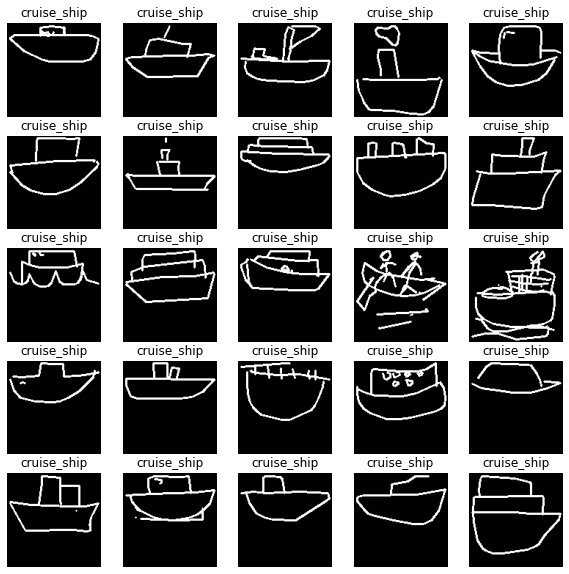

In [8]:
# === data_gen test ===

import cv2          # OpenCV 라이브러리 가져오기
# 첫 번째 배치 데이터 가져오기 및 시각화
xx, y = data_gen[0]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
labels = np.argmax(y, axis=1)  # 레이블 인덱스

# 이미지를 0에서 1 사이의 값으로 변환
xx = xx.astype(float) / 255.0

# 5x5 그리드에서 각 셀에 대해 이미지를 시각화하는 반복문
for i in range(25):
    axs[i // 5, i % 5].imshow(xx[i])  # 이미지 플로팅
    axs[i // 5, i % 5].axis('off')  # 축 숨기기
    axs[i // 5, i % 5].set_title(data_gen.label_names[labels[i]])  # 레이블 이름 설정

plt.show()

- 데이터 제너레이터로 데이터가 잘 출력되는것 확인!
- 이 제너레이터로 원래 하려고했던 tf.data.Dataset.from_generator 데이터셋 생성


- 💡 **데이터에 틀린 그림도 포함되어있다. 모델훈련후 문제가 되는 데이터는 제외하고 학습필요**

## step 2 - from_generator로 데이터셋 생성
- `watch -n 1 nvidia-smi` 로 터미널에서 메모리 사용량 체크 
    - 여기까지 256MiB/15109MiB 사용
- `%%time` 매직 명령 사용해서 해당 셀의 실행시간 체크
    - 34초 걸림

In [9]:
%%time

# Create a TensorFlow dataset using from_generator method
dataset = tf.data.Dataset.from_generator(
    lambda: data_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Image tensor
        tf.TensorSpec(shape=(None, len(label_names)), dtype=tf.int16)  # Label tensor
    )
)

# shuffle and prefetch the dataset
dataset = dataset.shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# dataset check
for images, labels in dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 128, 128, 3)
Labels shape: (32, 340)
CPU times: user 21.7 s, sys: 3.94 s, total: 25.6 s
Wall time: 34.6 s


### 데이터셋 시각화

In [13]:
import math

def show_batch(image_batch, label_batch, label_names):
    plt.figure(figsize=(15, 15))
    for i in range(len(image_batch)):
        ax = plt.subplot(4, math.ceil(len(image_batch)/4), i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label_index = tf.argmax(label_batch[i]).numpy() 
        plt.title(label_names[label_index])
        plt.axis("off")
    plt.show()

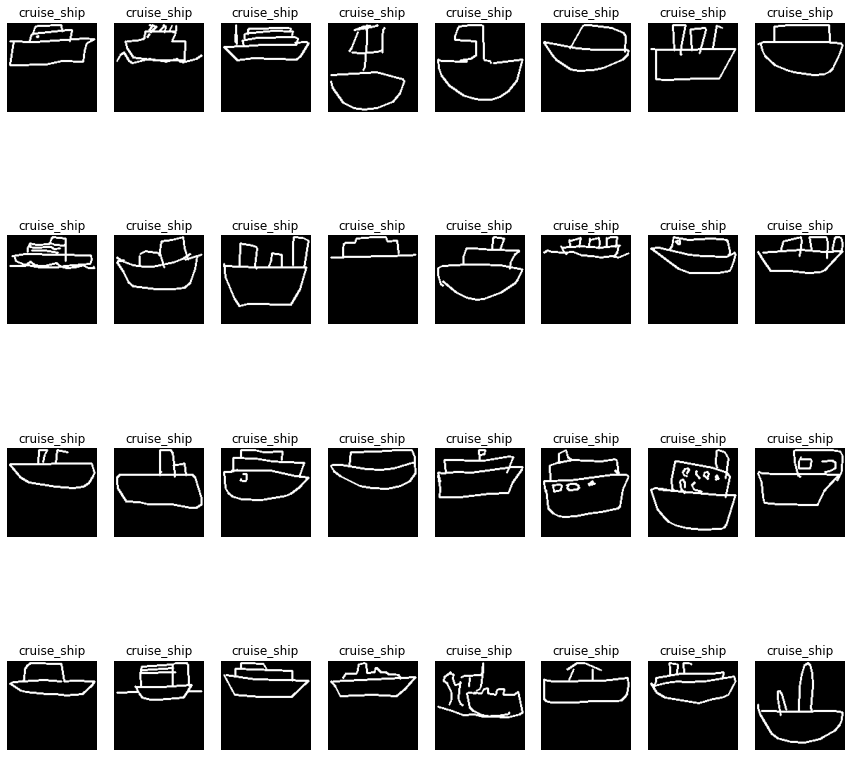

CPU times: user 23 s, sys: 3.2 s, total: 26.2 s
Wall time: 26 s


In [15]:
%%time
# 배치별로 이미지 확인
image_batch, label_batch = next(iter(dataset))
show_batch(image_batch, label_batch, label_names)

- 데이터셋이 전혀 섞이지 않은것같다. 
    - file path로 배치데이터셋이 만들어지는데 한 파일안에는 하나의 label만 있어서 각 레이블이 섞이지 않음

In [4]:
class ShuffledDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, label_paths, batch_size, shuffle_within_label=True):
        """
        ShuffledDataGenerator 클래스 생성자
        
        Args:
            label_paths (list): 각 레이블 CSV 파일 경로의 리스트
            batch_size (int): 배치 크기
            shuffle_within_label (bool): 각 레이블의 데이터셋 내에서 섞을지 여부
        """
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.shuffle_within_label = shuffle_within_label
        self.file_generators = [self._file_generator(label_path) for label_path in label_paths]
        self.indices = np.arange(len(self.file_generators)).repeat(batch_size)
        if shuffle_within_label:
            self._shuffle_within_label()

    def __len__(self):
        """
        제네레이터 내의 배치 수 리턴
        """
        return int(1e6) # 무한대 수를 넣고 train epoch로 훈련 중지 

    def __getitem__(self, idx):
        """
        데이터의 배치 생성
        
        Args:
            idx (int): 배치 인덱스
        
        Returns:
            list: 데이터를 포함하는 배치의 리스트
        """
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = [next(self.file_generators[i]) for i in batch_indices]
        return batch_data

    def _file_generator(self, label_path):
        """
        각 레이블 CSV 파일에서 데이터를 생성
        
        Args:
            label_path (str): 각 레이블 CSV 파일 경로
        
        Yields:
            DataFrame: DataFrame CSV 파일 데이터
        """
        while True:
            df = pd.read_csv(label_path, usecols=['drawing','word'])
            if self.shuffle_within_label:
                df = df.sample(frac=1)  # 레이블의 데이터셋 내에서 섞기
            for _, row in df.iterrows():
                yield row  # DataFrame의 각 행을 생성합니다.

    def _shuffle_within_label(self):
        """
        각 레이블의 데이터셋 내에서 인덱스를 섞기
        """
        np.random.shuffle(self.indices)

In [5]:
%%time
batch_size = 32
shuffle_within_label = True  # Whether to shuffle within each label's dataset
data_generator = ShuffledDataGenerator(csv_files, batch_size, shuffle_within_label)

CPU times: user 853 µs, sys: 0 ns, total: 853 µs
Wall time: 840 µs


In [7]:
# === data_generator test ===

import cv2          # OpenCV 라이브러리 가져오기
# 첫 번째 배치 데이터 가져오기 및 시각화
xx, y = data_generator[0]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
labels = np.argmax(y, axis=1)  # 레이블 인덱스

# 이미지를 0에서 1 사이의 값으로 변환
xx = xx.astype(float) / 255.0

# 5x5 그리드에서 각 셀에 대해 이미지를 시각화하는 반복문
for i in range(25):
    axs[i // 5, i % 5].imshow(xx[i])  # 이미지 플로팅
    axs[i // 5, i % 5].axis('off')  # 축 숨기기
    axs[i // 5, i % 5].set_title(data_gen.label_names[labels[i]])  # 레이블 이름 설정

plt.show()

ValueError: too many values to unpack (expected 2)

In [8]:
data_generator[0]

[drawing    [[[78, 76], [91, 147]], [[95, 86], [92, 143]],...
 word                                                     cow
 Name: 87654, dtype: object,
 drawing    [[[119, 57, 59, 53, 42, 30, 31, 51, 52, 11, 0,...
 word                                               hourglass
 Name: 73118, dtype: object,
 drawing    [[[1, 14, 38, 49, 51, 62, 31, 14, 0], [251, 47...
 word                                                  crayon
 Name: 19866, dtype: object,
 drawing    [[[95, 87, 67, 31, 22, 9, 1, 4, 15, 28, 75, 10...
 word                                                   beard
 Name: 17506, dtype: object,
 drawing    [[[28, 14, 0], [71, 125, 151]], [[236, 245, 25...
 word                                                   bench
 Name: 58682, dtype: object,
 drawing    [[[14, 12, 24, 31, 40, 42], [113, 129, 223, 24...
 word                                                  pencil
 Name: 33310, dtype: object,
 drawing    [[[85, 99, 114, 125, 150, 163, 177, 184, 184, ...
 word               

하나의 배치로 생성한 제너레이터 결과에 여러 레이블이 섞여있는건 확인
- 여기에 맞게 코드 수정